# Práctica 6a: Compilación y ejecución de programas.

## Objetivos

En este boletín se ilustrarán la codificación de las instrucciones en lenguaje ensamblador y en lenguaje máquina de la arquitectura Intel x86-64, así como el proceso de enlazado de programas y su posterior carga en memoria para ejecución. 
Para la realización de esta práctica se asume que el alumno posee unos conocimientos mínimos del manejo de Linux desde la línea de comandos, adquiridos en sesiones anteriores.

<font size="4">  
    <span style="color: red;">No olvides configurar Git para usar tu nombre y apellido(s), y tu dirección de correo electrónico universitario antes de comenzar.
    </span>
</font>

Edita las primeras líneas de la siguiente celda con tu nombre y email y ejecútala para configurar tu entorno Git antes de empezar.

In [1]:
# Establece tu identidad
git config --global user.name "Juan Fco Manzanares Gómez"
git config --global user.email "jf.manzanaresgomez@um.es"

# Establece el editor por defecto
# para los mensajes de commit
git config --global core.editor "gedit"

<br>
<font size="5">  
    <span style="color: red;"><b>IMPORTANTE:</b><br> Añade este fichero a tu repositorio-bitácora "fc-alumno" <b>ANTES</b> de comenzar a realizar los ejercicios.
    </span>
</font>  
<font size="4">  
    Sigue las instrucciones a continuación.
</font>

Recuerda que para poder registrar tu trabajo en tu bitácora personal de prácticas, debes evitar trabajar en una copia de este *notebook* que no esté bajo control de versiones en Git en tu repositorio. Por ello, **ANTES DE REALIZAR NINGÚN CAMBIO en este fichero asegúrate de COLOCARLO DENTRO DIRECTORIO DE TU REPOSITORIO-BITÁCORA `fc-alumno`** y añadirlo al repositorio:
1. Cierra esta pestaña del navegador sin guardar los cambios.
2. Muévelo desde donde lo hayas descargado del AV (p.ej. `$HOME/Descargas`) al directorio donde tengas tu repositorio (se recomienda `$HOME/fc-alumno`).
3. Añádelo al repositorio:
    * `git add practica6a-compilacion-boletin.ipynb`
    * `git commit -m "Añadiendo el notebook del boletín de la práctica 6a (sin empezar)"`

## La aplicación web *Compiler Explorer*.

*Compiler Explorer* es una aplicación web de código abierto disponible en https://godbolt.org, que permite escribir y compilar el código fuente de forma interactiva, todo desde la comodidad del navegador web. Permite elegir entre una amplia variedad de compiladores (GCC, *clang*, etc.) así como generar código para la mayoría de arquitecturas hardware actuales (x86-64, ARM, RISC-V, etc.). Tiene soporte para un gran número de lenguajes de programación, incluyendo lenguajes interpretados como Python, de manera que puedes observar cómo se compila a bytecode para ser ejecutado en la máquina virtual de Python.

Una de sus características más didácticas es que nos indica exactamente a qué instrucciones en el lenguaje ensamblador elegido se traduce cada línea del código fuente, como podemos ver en la siguiente imagen:

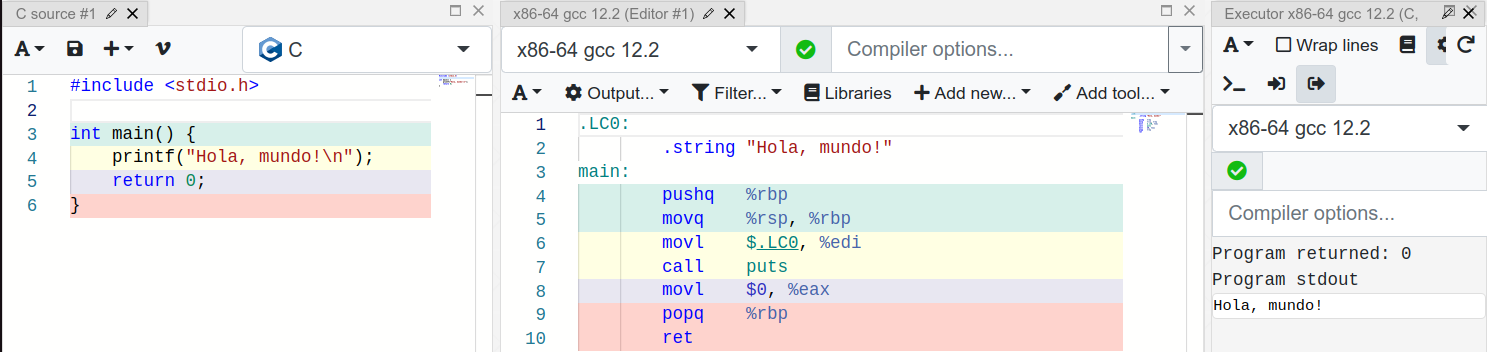

En la imagen anterior, vemos el código fuente en C del típico programa *hello world* junto con su traducción a código ensamblador del ISA x86-64 por parte del compilador GCC, donde mediante colores se nos indica la traducción correspondiente de cada sentencia en C a instrucciones en ensamblador.

## Traducción de código de alto nivel a lenguaje ensamblador y lenguaje máquina

Utilizaremos la aplicación web *Compiler Explorer* para mostrar la jerarquía de traducción y los distintos lenguajes del computador. Partiremos del fichero de código fuente en C `hola.c`, cuyo código es el siguiente, y que podemos generar ejecutando la siguiente celda:
```C
#include <stdio.h>

int main() {
    printf("Hola, mundo!\n");
}
```

In [2]:
# Ejecuta esta celda para generar el fichero hola.c
cat <<EOF > hola.c
#include <stdio.h>

int main() {
    printf("Hola, mundo!\n");
}
EOF

In [3]:
cat hola.c

#include <stdio.h>

int main() {
    printf("Hola, mundo!\n");
}


Una vez en el navegador, seleccionamos el lenguaje C en el panel izquierdo de código fuente (source) y a continuación copiamos y pegamos el código de `hola.c` en dicho panel.
- En el panel derecho podemos elegir el compilador a utilizar, si bien por ahora utilizaremos el compilador por defecto (`gcc` compilando para el ISA x86-64). 
- En el botón *Add new* podemos añadir un nuevo panel del tipo Executor from this para observar el resultado de la ejecución del programa.
- En el botón de Output del panel del compilador podemos elegir el formato de la salida: en nuestro caso, marcamos las opciones para generar código binario, ejecutar el código, y desmarcamos la opción de usar la sintaxis de Intel. (*En este boletín, usaremos la sintaxis de AT&T, que es la que utiliza el compilador GCC por defecto. El formato general de una instrucción en ensamblador x86-64 usand dicha sintaxis es:* `mnemonic source, destination.`)

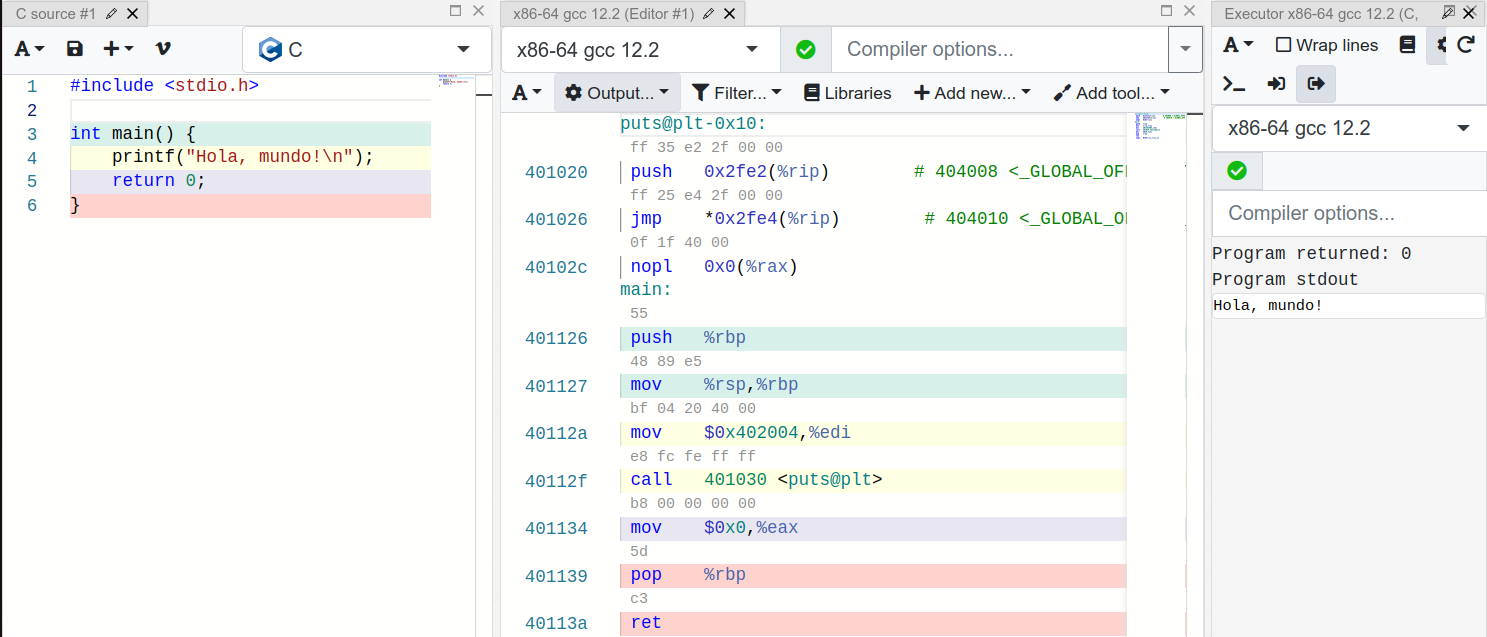

En la imagen anterior podemos ver que en el repertorio de instrucciones del ISA x86-64 encontramos:
- Instrucciones `push` y `pop`, utilizadas para guardar/recuperar datos en/de la pila.
- Instrucciones `mov`, para copiar datos de una ubicación a otra, (p.ej., de un registro a otro).
- Instrucciones `call` y `ret`, para llamar/regresar de procedimientos.

Encima de cada instrucción en ensamblador podemos ver su codificación en lenguaje máquina, mientras que a su izquierda tendríamos el *contador de programa* (su dirección en memoria). 

**Codificación de las instrucciones en lenguaje máquina**. Vemos que en x86 hay instrucciones que se codifican en un único byte (p.ej., `0x55` codifica la instrucción `push %rbp`), mientras que otras instrucciones ocupan varios bytes. 

**Operandos de las instrucciones**. La mayoría de instrucciones utilizan como operando algún registro (p.ej., `%rbp`, `%eax`, `%edi`, etc.), mientras que algunas instrucciones tienen como operandos valores constantes que aparecen codificados en la propia instrucción (*inmediatos*). Por ejemplo, la instrucción `mov $0x0,$eax`, que establece el registro de 32 bits EAX con el valor 0, se codifica en cinco bytes (`b8 00 00 00 00`), de los cuales los cuatro últimos bytes codifican el valor entero al que se establecerá el registro. 

**Llamadas a funciones**. Por su parte, la instrucción `call puts` transfiere la ejecución a la
función de la biblioteca de C *puts*, que "pone" (imprime) una cadena (*string*) por pantalla. 

**Paso de parámetros**. El convenio de llamadas que sigue Linux para x86-64 dictamina que el registro EDI se debe utilizar para pasar el primer parámetro a una función. Así, vemos que con anterioridad a la instrucción `call puts` se establece el registro EDI con el valor del parámetro pasado a la función, en este caso la dirección en memoria de la cadena de caracteres “Hola, mundo!” que queremos imprimir. El
mismo convenio establece que las funciones utilizan el registro EAX para devolver un valor antes de ejecutar ret;
como vemos, la línea 5 del código fuente en C se traduce (en parte) por el establecimiento del registro EAX al valor
0, que es el valor retornado por el programa, tal y como podemos ver en el panel “ejecutor” del lado derecho.

## Proceso de construcción de un programa con GCC

Vamos a ver ahora cómo llevar a cabo los diferentes pasos en la jerarquía de traducción en un entorno Linux,
utilizando para ello el compilador GCC. Si bien sus siglas originalmente provienen de GNU C Compiler, hoy en día
GCC es una colección de compiladores con soporte para múltiples lenguajes de programación. GCC es un componente
clave de la cadena de herramientas de GNU y el compilador estándar para la mayoría de los proyectos relacionados
con GNU y el núcleo de Linux.

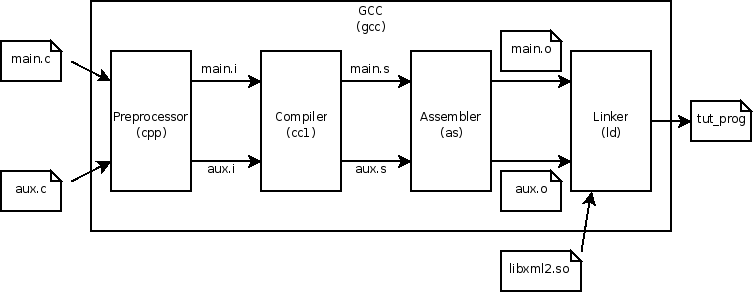

Al invocar `gcc` pasando como parámetros ficheros de código fuente en C y sin especificar ninguna opción adicional, se llevan a cabo por defecto todas las etapas del proceso de traducción hasta generar un programa ejecutable: **compilación, ensamblado y enlazado**. Este es el comportamiento por defecto que deseamos, ya que es lo que la gran mayoría de veces desea realizar cualquier programador en el proceso de desarrollo de código en un lenguaje compilado como C o C++. 

En primer lugar, simplemente compilaremos con `gcc` el programa `hola.c` para obtener un fichero ejecutable llamado `hola`; la opción `-o` (*output*) sirve para indicar el nombre del fichero compilado generado. Utilizamos para ello el siguiente comando:

In [1]:
# Realizamos compilación+ensamblado+enlazado
gcc hola.c -o hola

Comprobamos que, efectivamente, se ha generado un fichero `hola`, con los permisos de ejecución adecuados (`rwx`):

In [2]:
ls -l hola*

-rwxrwxr-x 1 kiko kiko 15960 dic  4 16:31 hola
-rw-rw-r-- 1 kiko kiko    65 nov 28 20:16 hola.c


A continuación, simplemente ejecutamos dicho programa:

In [3]:
./hola

Hola, mundo!


### Generación de código ensamblador

Sin embargo, es posible realizar mediante GCC las sucesivas etapas de traducción. Por ejemplo, con la opción `-S` podemos realizar únicamente la etapa de compilación, generando el correspondiente fichero con lenguaje ensamblador del Intel x86-64.

In [4]:
# Con -S, realizamos sólo la compilación a lenguaje ensamblador
gcc hola.c -S

El resultado de la compilación es un nuevo fichero de texto ASCII llamado `hola.s`:

In [5]:
ls -l hola*

-rwxrwxr-x 1 kiko kiko 15960 dic  4 16:31 hola
-rw-rw-r-- 1 kiko kiko    65 nov 28 20:16 hola.c
-rw-rw-r-- 1 kiko kiko   664 dic  4 16:32 hola.s


In [6]:
# Mostramos las primeras 25 líneas del programa ensamblador generado.
# Eliminamos con "grep -v" algunas directivas generadas, para mayor claridad
head -n25 hola.s | grep -v cfi | grep -v section

	.file	"hola.c"
	.text
.LC0:
	.string	"Hola, mundo!"
	.text
	.globl	main
	.type	main, @function
main:
.LFB0:
	endbr64
	pushq	%rbp
	movq	%rsp, %rbp
	leaq	.LC0(%rip), %rax
	movq	%rax, %rdi
	call	puts@PLT
	movl	$0, %eax
	popq	%rbp
	ret


El contenido más relevante se muestra a continuación. Vemos que el contenido del fichero generado es similar al mostrado, salvo por algunas directivas adicionales (fácilmente identificadas ya que empiezan por el carácter “.”). El compilador genera estas directivas para controlar el proceso de ensamblado; por ejemplo, la directiva  `.text` marca el inicio de la sección de código, en la que se encuentran las instrucciones.

```
        [...]
        .section        .rodata
.LC0:
        .string "Hola, mundo!"

        .text
        [...]
main:
        [...]
        movq    %rax, %rdi
        call    puts@PLT
        [...]
```

### Generación de código objeto

Ahora vamos a ensamblar el fichero en lenguaje ensamblador `hola.s` producido en el paso anterior, con el fin de generar el correspondiente fichero de código objeto `hola.o`. Aunque en realidad el programa ensamblador es independiente (llamado `as`), resulta más cómodo utilizar `gcc` como *front-end* para hacer cualquiera de las etapas de la traducción. Así, con este sencillo comando estamos invocando al ensamblador:

In [7]:
# Ensamblamos el código ensamblador para generar código objeto (en lenguaje máquina)
gcc -c hola.s

In [8]:
# la opción -t de ls ordena por fecha de modificación (más recientes primero)
ls -lt hola*

-rw-rw-r-- 1 kiko kiko  1496 dic  4 16:35 hola.o
-rw-rw-r-- 1 kiko kiko   664 dic  4 16:32 hola.s
-rwxrwxr-x 1 kiko kiko 15960 dic  4 16:31 hola
-rw-rw-r-- 1 kiko kiko    65 nov 28 20:16 hola.c


Como podemos comprobar mostrando su contenido con `cat` que el fichero `hola.o` generado por el comando anterior ya no es un fichero de texto sino un fichero binario: contiene el programa con sus instrucciones y datos codificados en lenguaje máquina. Recordemos que la razón principal por la que no se pueden ejecutar directamente los ficheros de código objeto es que les falta información necesaria para ser un programa completo. Estos archivos objeto contienen código máquina, pero aún no han sido vinculados con otras bibliotecas y otros módulos de código objeto que el programa final puede requerir para funcionar correctamente.

In [9]:
cat hola.o

                              9      0               k       ,                             B                      �                                      R                     �                                      j                     �       8                              e      @               �                	                                       �       �                           	                      �                                                          �      t                              

Para poder interpretar su contenido debemos utilizar una herramienta llamada desensamblador, que realiza la traducción *inversa* desde código máquina a ensamblador, mediante el siguiente comando:

In [10]:
objdump -d hola.o


hola.o:     formato del fichero elf64-x86-64


Desensamblado de la sección .text:

0000000000000000 <main>:
   0:	f3 0f 1e fa          	endbr64 
   4:	55                   	push   %rbp
   5:	48 89 e5             	mov    %rsp,%rbp
   8:	48 8d 05 00 00 00 00 	lea    0x0(%rip),%rax        # f <main+0xf>
   f:	48 89 c7             	mov    %rax,%rdi
  12:	e8 00 00 00 00       	call   17 <main+0x17>
  17:	b8 00 00 00 00       	mov    $0x0,%eax
  1c:	5d                   	pop    %rbp
  1d:	c3                   	ret    


En él podemos comprobar cómo el código correspondiente a la función main del programa se muestra convenientemente formateado en tres columnas: para cada instrucción, la primera columna indica su desplazamiento relativo al comienzo del fichero objeto, la segunda su código máquina (mostrado como secuencia de bytes, en hexadecimal), y
finalmente una tercera columna donde se muestra el código ensamblador correspondiente a dicha instrucción.

### Enlazado

El programa `ld` del toolkit de GCC se encarga hacer el enlazado de código(s) objeto(s) y biblioteca(s) en un sólo fichero ejecutable. No obstante, el propio `gcc` se puede encargar de llamarlo por nosotros, ya que el comando de enlazado usado internamente es más complicado. Así que, para generar el ejecutable `hola` a partir del anterior fichero objeto `hola.o`, simplemente podemos ejecutar:

In [11]:
# Enlazamos el código objeto con las bibliotecas para generar un ejecutable
gcc hola.o -o hola

In [12]:
ls -lt hola*

-rwxrwxr-x 1 kiko kiko 15960 dic  4 16:37 hola
-rw-rw-r-- 1 kiko kiko  1496 dic  4 16:35 hola.o
-rw-rw-r-- 1 kiko kiko   664 dic  4 16:32 hola.s
-rw-rw-r-- 1 kiko kiko    65 nov 28 20:16 hola.c


### Bibliotecas dinámicas

El ejecutable generado se puede probar directamente, tecleando el comando `./hola` como hicimos en la sección anterior. Pero en este momento nos interesa más comprobar las bibliotecas dinámicas con las
que enlaza nuestro ejecutable generado. Para ello usamos el comando `ldd`:

In [13]:
ldd hola

	linux-vdso.so.1 (0x00007ffce4da2000)
	libc.so.6 => /lib/x86_64-linux-gnu/libc.so.6 (0x00007fa982000000)
	/lib64/ld-linux-x86-64.so.2 (0x00007fa9823e8000)


Cada línea nos dice el fichero donde se encuentra la biblioteca dinámica correspondiente, y la dirección virtual
de nuestro programa a la que las rutinas allí contenidas son mapeadas. 
- En particular, la biblioteca que aquí más nos interesa es la **biblioteca estándar de C** (`libc`), que contiene, entre otras muchas utilidades, la función `puts` usada por nuestro programa. 
- Las otras dos bibliotecas (`linux-vdso` y `ld-linux-x86-64`) se corresponden, respectivamente, con las llamadas al sistema de Linux (que, como tal, están en el código del núcleo, siempre cargado desde el arranque en memoria, y por tanto no necesitan fichero para almacenarse), y la propia biblioteca que gestiona la posibilidad de carga dinámica de bibliotecas en memoria, para ser compartidas entre varios programas.

In [14]:
LIBC_PATH=$(ldd hola | grep libc | rev | cut -d " " -f2 | rev)
echo $LIBC_PATH

/lib/x86_64-linux-gnu/libc.so.6


Este fichero con la biblioteca debe estar disponible en el sistema para que el programa enlazado dinámicamente funcione.

In [15]:
ls -lh $LIBC_PATH

-rwxr-xr-x 1 root root 2,2M sep 25 16:45 /lib/x86_64-linux-gnu/libc.so.6


Podemos comprobar que efectivamente ese fichero contiene el código de la función `puts` que utiliza nuestro programa:

In [16]:
objdump -d $LIBC_PATH | grep -A20 "<_IO_puts>:"

0000000000080e50 <_IO_puts>:
   80e50:	f3 0f 1e fa          	endbr64 
   80e54:	41 56                	push   %r14
   80e56:	41 55                	push   %r13
   80e58:	41 54                	push   %r12
   80e5a:	49 89 fc             	mov    %rdi,%r12
   80e5d:	55                   	push   %rbp
   80e5e:	53                   	push   %rbx
   80e5f:	48 83 ec 10          	sub    $0x10,%rsp
   80e63:	e8 28 76 fa ff       	call   28490 <*ABS*+0xa86a0@plt>
   80e68:	4c 8b 2d c9 7f 19 00 	mov    0x197fc9(%rip),%r13        # 218e38 <stdout@@GLIBC_2.2.5-0x1a30>
   80e6f:	48 89 c3             	mov    %rax,%rbx
   80e72:	49 8b 6d 00          	mov    0x0(%r13),%rbp
   80e76:	8b 45 00             	mov    0x0(%rbp),%eax
   80e79:	25 00 80 00 00       	and    $0x8000,%eax
   80e7e:	75 58                	jne    80ed8 <_IO_puts+0x88>
   80e80:	64 4c 8b 34 25 10 00 	mov    %fs:0x10,%r14
   80e87:	00 00 
   80e89:	4c 8b 85 88 00 00 00 	mov    0x88(%rbp),%r8
   80e90:	4d 39 70 08          	cmp    %r14,0x8(

Puesto que el ejecutable generado enlaza con bibliotecas dinámicas, su tamaño tiende a ser bastante pequeño
(en torno a los 16KB, dependiendo también de la versión concreta de `gcc` utilizada).

In [17]:
ls -lh hola*

-rwxrwxr-x 1 kiko kiko  16K dic  4 16:37 hola
-rw-rw-r-- 1 kiko kiko   65 nov 28 20:16 hola.c
-rw-rw-r-- 1 kiko kiko 1,5K dic  4 16:35 hola.o
-rw-rw-r-- 1 kiko kiko  664 dic  4 16:32 hola.s


### Bibliotecas estáticas

Sin embargo, tal vez podría interesarnos generar un ejecutable estático, que sea autocontenido, y por tanto no dependa de bibliotecas dinámicas externas. Para ello, simplemente hay que compilar con la opción `-static`:

In [18]:
gcc -static hola.o -o hola.static

Esta vez podemos comprobar que el ejecutable generado no enlaza con ninguna biblioteca dinámica:

In [19]:
ldd hola.static

	no es un ejecutable dinámico


: 1

A cambio, se tiene que pagar un precio en el tamaño del ejecutable. En este caso, el fichero ocupa en torno a 900KB, dependiendo de las versiones tanto del compilador como de la biblioteca `libc` con la que haya enlazado. 

In [20]:
ls -lh hola*

-rwxrwxr-x 1 kiko kiko  16K dic  4 16:37 hola
-rw-rw-r-- 1 kiko kiko   65 nov 28 20:16 hola.c
-rw-rw-r-- 1 kiko kiko 1,5K dic  4 16:35 hola.o
-rw-rw-r-- 1 kiko kiko  664 dic  4 16:32 hola.s
-rwxrwxr-x 1 kiko kiko 880K dic  4 16:40 hola.static


Para conocer de primera mano la razón por la que el ejecutable resultante de enlazar estáticamente tiene un tamaño mucho mayor, podemos llevar a cabo su desensamblado y contar el número de líneas (instrucciones en ensamblador) que contiene.

In [21]:
objdump -d hola.static | wc -l

154199


Si lo comparamos con el número de líneas (instrucciones en ensamblador) del ejecutable enlazado dinámicamente, vemos claramente la diferencia:

In [22]:
objdump -d hola | wc -l

132


In [23]:
objdump -d hola.static | nl | grep -A9 "<main>"

   519	0000000000401775 <main>:
   520	  401775:	f3 0f 1e fa          	endbr64 
   521	  401779:	55                   	push   %rbp
   522	  40177a:	48 89 e5             	mov    %rsp,%rbp
   523	  40177d:	48 8d 05 80 68 09 00 	lea    0x96880(%rip),%rax        # 498004 <_IO_stdin_used+0x4>
   524	  401784:	48 89 c7             	mov    %rax,%rdi
   525	  401787:	e8 f4 a9 00 00       	call   40c180 <_IO_puts>
   526	  40178c:	b8 00 00 00 00       	mov    $0x0,%eax
   527	  401791:	5d                   	pop    %rbp
   528	  401792:	c3                   	ret    


Podemos numerar las líneas (con `nl`) del listado de código desensamblado generado, y luego usar `grep` para localizar las partes del código correspondientes a la función `puts` utilizada (en realidad llamada `IO_puts`):

In [24]:
objdump -d hola.static | nl | grep -A10 "<_IO_puts>:"

 11383	000000000040c180 <_IO_puts>:
 11384	  40c180:	f3 0f 1e fa          	endbr64 
 11385	  40c184:	41 55                	push   %r13
 11386	  40c186:	41 54                	push   %r12
 11387	  40c188:	49 89 fc             	mov    %rdi,%r12
 11388	  40c18b:	55                   	push   %rbp
 11389	  40c18c:	53                   	push   %rbx
 11390	  40c18d:	48 83 ec 18          	sub    $0x18,%rsp
 11391	  40c191:	e8 ea 4f ff ff       	call   401180 <_init+0x180>
 11392	  40c196:	48 8b 2d 53 95 0b 00 	mov    0xb9553(%rip),%rbp        # 4c56f0 <stdout>
 11393	  40c19d:	48 89 c3             	mov    %rax,%rbx


### Carga en memoria de un fichero ejecutable 

El depurador GDB nos permitirá cargar nuestro programa en memoria para poder ejecutarlo dentro de un entorno controlado, donde podamos ir ejecutándolo paso a paso, observando los valores de las variables, y tengamos acceso tanto a los registros de la CPU como a las zonas de datos e instrucciones del programa. 

Para poder utilizar GDB adecuadamente, vamos a generar de nuevo un fichero ejecutable `hola.static`, enlazado estáticamente, mediante compilación directa a partir del fuente en C original. Sin embargo, en este caso le añadimos la opción `-g` al invocar  `gcc` para indicarle que incluya en el fichero ejecutable la información necesaria para su *depuración* con GDB:

In [25]:
gcc -g -static hola.c -o hola.static

Una vez generado el ejecutable “traceable”, lanzamos el depurador `gdb`. Puesto que debemos interactuar con el *shell* de `gdb` a través de teclado, debemos lanzarlo desde un terminal, ya que en un *notebook* esto no es posible.

```bash
$ gdb ./hola.static
```

Con ello se arranca el programa `gdb`, que tiene su propio intérprete (*shell*), y donde podemos empezar a teclear una serie de comandos: 
- El comando `break` sirve para establecer un punto de ruptura en una línea código o una determinada función, de manera que la ejecución del programa se detendrá en ese punto. 
- El comando `run` sirve para lanzar el programa a ejecución. 
- Mediante el comando `layout split` podemos activar la interfaz TUI (*distintos paneles en modo textual*), de forma que nos aparezcan dos paneles: en el superior, el código fuente del programa, y en el inferior, su traducción a código ensamblador, resultado de desensamblar el código máquina contenido en el fichero con el programa ejecutable.

La siguiente imagen muestra el resultado de lanzar `gdb` con el programa `hola.static` y activar la interfaz TUI para ver tanto código de alto nivel como el de bajo nivel.

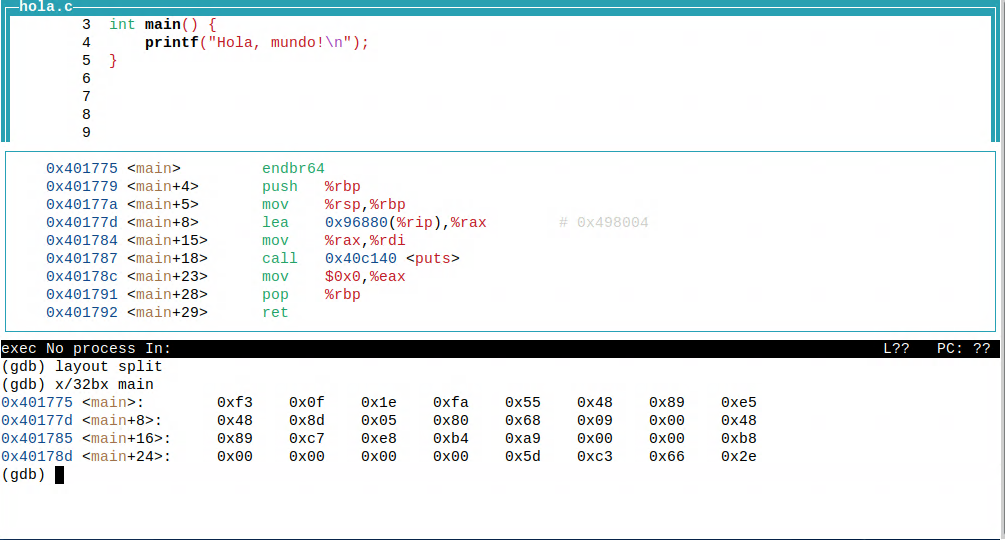

**Ubicación del código en memoria.** Se trata esencialmente del mismo código que se vio anteriormente cuando usamos el comando `objdump` sobre el fichero de código objeto, pero son varias las diferencias claves a observar entre aquel y el código desensamblado correspondiente al programa ya cargado en memoria:

1. En primer lugar, se observa que el código cargado en el gdb está ya ubicado en direcciones virtuales concretas (a partir de la 0x401775 en nuestro ejemplo, correspondiente al comienzo de la función `main`), frente a las direcciones relativas a 0 del código objeto original.

2. En segundo lugar, y como consecuencia de lo anterior, las propias direcciones codificadas en algunas instrucciones (p.e., llamadas a subrutinas o accesos a variables en memoria) contienen ya direcciones definitivas. Por ejemplo, la instrucción call en el desplazamiento main+18, que en el código objeto de `hola.o` (desplazamiento 0x12) se había codificado dejando los 4 huecos de bytes para la dirección a cero (secuencia de código máquina `e8 00 00 00 00`), ha sido traducida en el código final, ya reubicado, a la instrucción call 40c180 <puts>.

Si usamos el comando de GDB `x/32bx main` para examinar el contenido de los 32 bytes en memoria a partir de la dirección donde se ubica `main`, podemos ver las instrucciones en código máquina: por ejemplo, en la dirección 0x401787 (main+18) empieza la secuencia de bytes e8 f4 a9 00` correspondientes a la instrucción `call puts`. 

### Ejecución paso a paso de un programa con GDB

Ahora vamos a ejecutar paso a paso el programa, observando cómo cambian los valores de determinados registros
del procesador. 

1. Ponemos un breakpoint (punto de ruptura) al comienzo del programa mediante el comando `break main`.
2. Lanzamos el programa a ejecución (comando `run`). 
3. Una vez detenida la ejecución en el breakpoint, podemos ejecutar paso a paso el programa. En este caso, lo haremos de instrucción en instrucción (a nivel de código ensamblador) mediante el comando `stepi`. 
4. Mostramos el valor de los registros RIP y RAX con `info registers rax rip`.
5. Examinamos el contenido de los 13 bytes en memoria a partir de la dirección apuntada por RAX (`x/13bc 0x498004`).

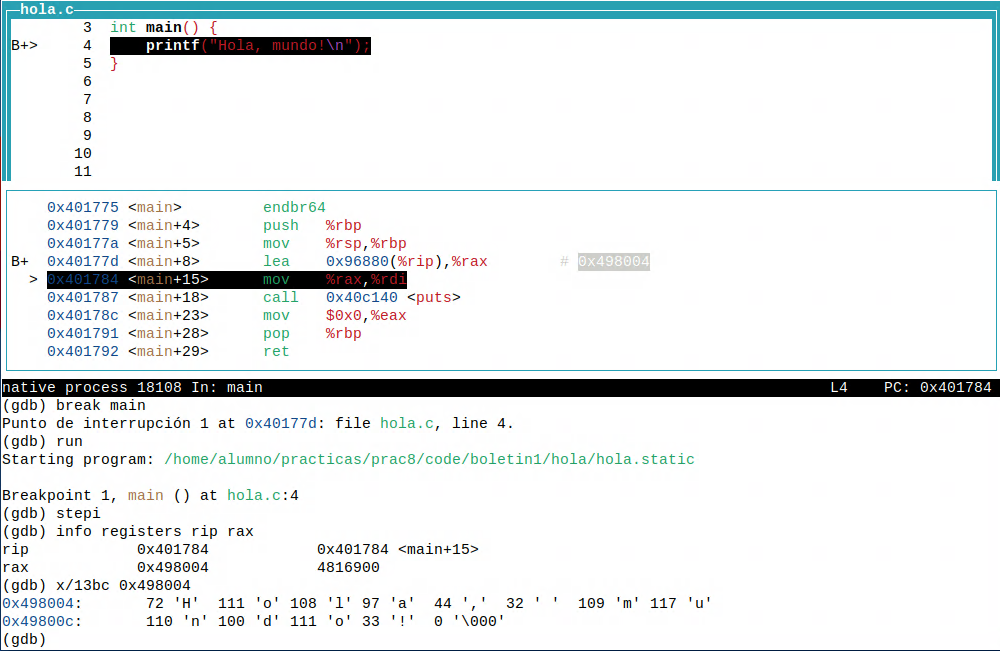

Vemos que el el registro RIP contiene la dirección de la instrucción que se va a ejecutar a continuación (0x401784, es decir, main+15).

También vemos que el registro RAX, que acaba de ser escrito por la instrucción anterior, contiene el valor que se va a pasar como **parámetro** a la función `puts`, y que no es otro que la dirección en memoria de la cadena de caracteres que queremos imprimir por pantalla. 

Si examinamos el contenido de los 13 bytes en memoria a partir de la dirección apuntada por RAX (x/13bc 0x498004), veremos que efectivamente están almacenados los caracteres ’H’, ’o’, ’l’, etc.,
correspondientes a la cadena “Hola, mundo!”.

### Ubicación de las variables globales en memoria

Ejecutamos la siguiente celda para generar el fichero `globals.c`. Se trata de un programa en C, que recorre un array y establece el valor de todos los elementos a -1.

```C
#define ARRAY_SIZE 10

int array[ARRAY_SIZE] = {10,9,8,7,6,5,4,3,2,1};

int main() {
    int i = 0;
    while(i < ARRAY_SIZE) {
        array[i] = -1;
        ++i;
    }
}
```

In [26]:
# Ejecuta esta celda para generar el fichero hola.c
cat <<EOF > globals.c
#define ARRAY_SIZE 10

int array[ARRAY_SIZE] = {10,9,8,7,6,5,4,3,2,1};

int main() {
    int i = 0;
    while(i < ARRAY_SIZE) {
        array[i] = -1;
        ++i;
    }
}
EOF

Generamos a partir del código fuente un fichero ejecutable `globals` enlazado estáticamente, mediante compilación directa, incluyendo la información necesaria para poder tracearlo, y a continuación lo depuramos con GDB:

In [27]:
gcc -g -static globals.c -o globals.static

```bash
$ gdb ./globals.static
```

Con el comando `x/40bx array` examinamos los 40 bytes (mostrados en hexadecimal) que ocupa el vector `array`, y así ver qué direcciones de memoria ocupa:

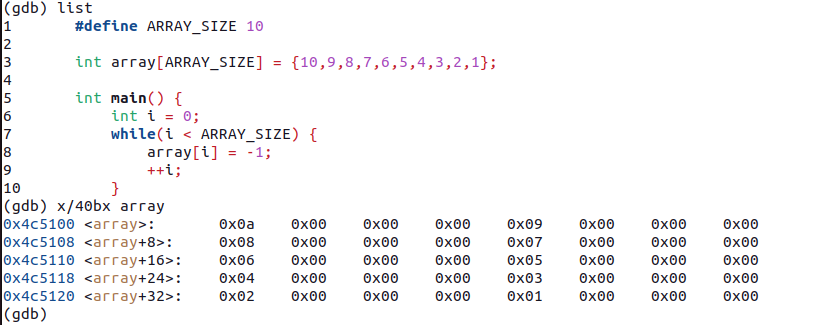

Vemos que la variable `array` está ubicada a partir de la dirección 0x4c51000, que cada elemento del array ocupa 4 bytes (32 bits) por cada entero, los cuales están almacenados en memoria según el esquema de almacenamiento usado por el ISA x86-64 (little endian). El depurador GDB tiene una forma más cómoda de imprimir los contenidos
de un array, aprovechando que *conoce* el código en C que lo generó:

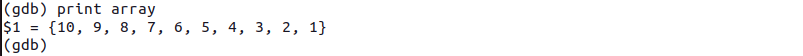

Ahora vamos a ejecutar el programa de forma controlada para observar el comportamiento dinámico del mismo
y observar cómo cambian los valores de las variables en memoria. 

Para ello:
1. Listamos el código (comando `list`)
2. Ponemos un punto de ruptura dentro del cuerpo del bucle *while* (comando `break 8`). 
3. Comenzamos la ejecución (comando `run`):
El programa se detendrá justo cuando ya se va a establecer a -1 el primer elemento del array (`array[0]`).

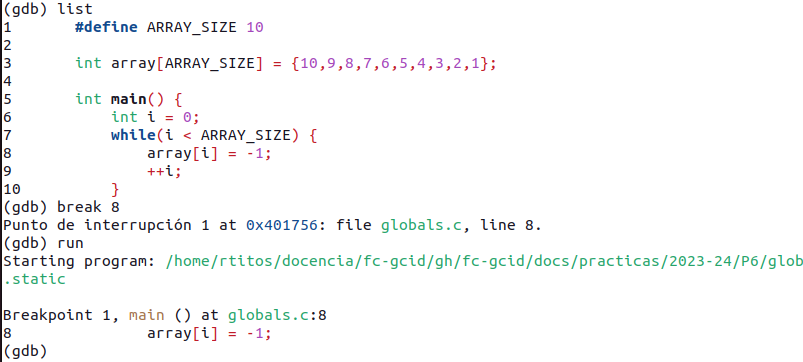

Una vez el programa se detiene en el *breakpoint*, podemos inspeccionar los datos (comandos `print array` o `x/40bx array`) en este punto. Si ejecutamos la sentencia en la línea 8 con el comando `next` y a continuación volvemos a visualizar el contenido del array en memoria, veremos que el primer elemento ahora vale -1, cuya representación en complemento es una ristra de bits de 32 unos.

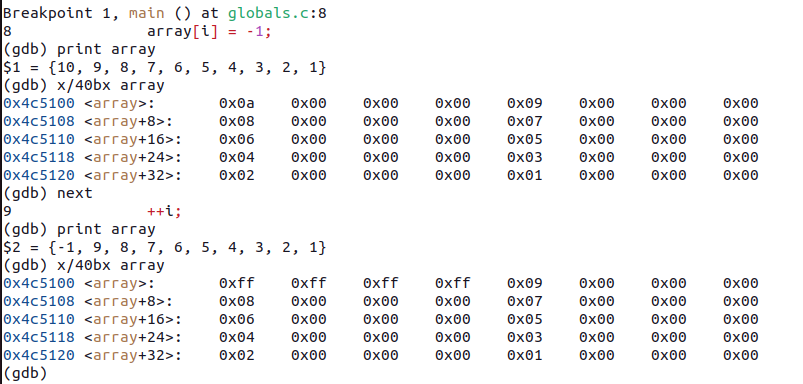

Por último, veamos cómo es el propio código ensamblador que estamos ejecutando (comando `disassemble`) y el contenido de algunos registros del procesador (comando `info registers`) en el punto que está detenido el programa.

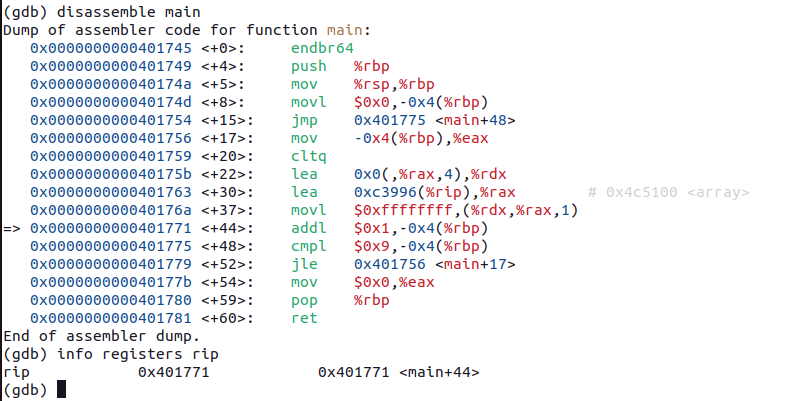

Vemos que el valor del registro RIP indica en todo momento la dirección de la instrucción a ejecutar. En el punto donde está detenido el programa en la imagen anterior, es la dirección de memoria 0x401771, donde se encuentra el código máquina de la instrucción `addl   $0x1,-0x4(%rbp)`.